# Лабораторная работа по Relevance Vector Regression
В рамках этой лабораторной работы необходимо:
- Имплементировать Relevance Vector Regression
- Применить на синетическом датасете (восстановление полинома), сравнить с Lasso из sklearn и гребневой регрессией
- Применить на данных sinc с RBF признаками, визуализировать "релевантные вектора", сравнить с Support Vector Regression и Lasso
- Сделать выводы

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook, tqdm

%matplotlib inline
np.random.seed(123)

def l2_error(X, t, w):
    return np.sum((X.dot(w.ravel()) - t) ** 2)

## Имплементация Relevance Vector Regression

Здесь необходимо реализовать три функции:

1. `get_w_sigma(X, t, alpha, beta)`, которая принимает датасет (X, t) и гиперпараметры RVR (alpha, beta) и возвращает параметры апостериорного распределения mu, sigma
2. `update_alpha_beta(X, t, alpha, beta)`, которая принимает датасет (X, t) и гиперпараметры RVR (alpha, beta) и делает один шаг итерационной процедуры для обновления гиперпараметров (было на лекции)
3. `fit_rvr(X, t, max_iters)`, которая принимает датасет (X, t) и максимальное количество итераций и возвращает обученные гиперпараметры и параметры апостериорного распределения на веса модели

На что стоит обратить внимание:

1. Результаты дорогостоящих операций типа перемножения одних и тех же матриц нужно кешировать и переиспользовать
2. $\alpha$-ы для нерелевантных объектов должны принять значение `np.inf`, а соответствующие веса и их дисперсии должны иметь значение 0
3. Бесконечности и нули из предыдущего пункта должны обрабатываться корректно, без NaN-ов и warning-ов
4. Матрицу с бесконечными элементами на диагонали можно обращать более эффективно (достаточно обратить подматрицу)

In [5]:
import xxhash

def np_cache(function):
    """
    Декоратор для кэширования с использованием алгоритма быстрого хэширования xxhash
    
    TODO: задать максимальный размер кэша
    TODO: проверить, возможно простое поэлементное сравнение будет работать быстрее
    TODO: сделать проверку на коллизии
    """
    cache = dict()
    h = xxhash.xxh64()
    
    def wrapper(*np_arrays):
        hashes = []
        for np_array in np_arrays:
            
            h.update(np_array)
            np_hash = h.intdigest()
            h.reset()
            
            hashes.append(np_hash)
            
        hashes = tuple(hashes)
        if not hashes in cache.items():
            cache[hashes] = function(*np_arrays)
            return cache[hashes]
        else:
            return cache[hashes]
    
    return wrapper
            
    
@np_cache
def get_basic_cavariance_matrix(X):
    return X.T @ X


@np_cache
def get_XT_t(X, t):
    return X.T @ t


def inversion_with_inf(X):
    """
    Обращение матрицы с np.inf'ами на диагонали.
    """
    rows, cols = np.where(np.isinf(X))
    if rows.shape[0] == 0:
        with np.errstate(divide="ignore"):
            return np.linalg.inv(X)
    
    X_new = X
    X_new = np.delete(X_new, rows, 0)
    X_new = np.delete(X_new, cols, 0)
#     for i, j in reversed(list(zip(rows, cols))):
#         X_new = np.delete(X_new, i, 0)
#         X_new = np.delete(X_new, j, 1)
    
    X_inv = np.linalg.inv(X_new)
    
    X_inv = np.insert(X_inv, rows, 0, axis=0)
    X_inv = np.insert(X_inv, cols, 0, axis=1)
#     for i, j in zip(rows, cols):
#         X_inv = np.insert(X_inv, i, 0, axis=0)
#         X_inv = np.insert(X_inv, j, 0, axis=1)
        
    return X_inv


def get_covariance_matrix_optimized(X, alpha, beta):
    """
    :param X: матрица размером n x d
    :param alpha: 1-мерный массив размером d
    :param beta: скаляр
    
    Считает ковариационную матрицу
    использует следующие оптимизации:
        1. Матрицу с бесконечными элементами на диагонали обращает с помощью подматрицы
    """    
    sigma_inv = get_basic_cavariance_matrix(X) * beta + np.diag(alpha)
    
    return inversion_with_inf(sigma_inv)


def get_w_sigma(X, t, alpha, beta):
    """
    Calculate the mean and the covariance matrix
    of the posterior distribution
    """
    n, d = X.shape
    
    # YOUR CODE GOES HERE
    sigma = get_covariance_matrix_optimized(X, alpha, beta)
    w = beta * (sigma @ get_XT_t(X, t)) # (d x d) @ (d x n) @ (n x 1) -> d x 1
    
    return w, sigma


def update_alpha_beta(X, t, alpha, beta):
    """Update the hyperperemeters to increase evidence"""

    # YOUR CODE GOES HERE
    w, sigma = get_w_sigma(X, t, alpha, beta)
    n, d = X.shape
    
    # временная переменная, чтобы не считать два раза сумму
    # при умножении np.inf на 0 возникает nan
    # чтобы от него избавиться примем, что np.inf * 0 = 0
    diag = np.diag(sigma)
    alpha_new_numerator = 1 - np.multiply(alpha, diag, out=np.zeros_like(alpha), where=diag!=0)
    
    beta_new = (n - np.sum(alpha_new_numerator)) / l2_error(X, t, w)
    alpha_new = np.divide(alpha_new_numerator, w**2 + 1e-16, out=np.full(w.shape, np.inf), where=(w!=0))    
    
    return alpha_new, beta_new


def fit_rvr(X, t, max_iter=10000):
    """Train the Relevance Vector Regression model"""

    # YOUR CODE GOES HERE
    n, d = X.shape
    
    alpha = np.full(d, 1e-6)
    beta = 1.e-6
    
    for i in tqdm(range(max_iter)):
#         w, sigma = get_w_sigma(X, t, alpha, beta)
        alpha, beta = update_alpha_beta(X, t, alpha, beta)
    
    w, sigma = get_w_sigma(X, t, alpha, beta)
    
    return w, sigma, alpha, beta

## Восстановление полинома

Здесь решается модельная задача: зашумленным полиномом третьей степени сгенерированы данные для задачи регрессии. Нужно на этих данных обучить многочлен степени, не превышающей 20. Предлагается сравнить три модели: гребневую регрессию, L1-регрессию (Lasso) и RVR, и сравнить ошибку на тестовой выборке и качество отобранных признаков.

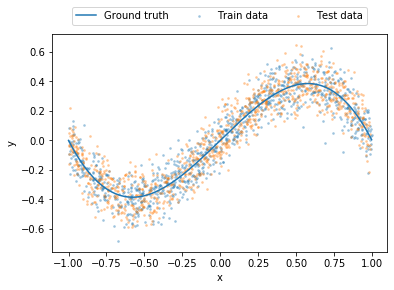

In [3]:
# Data generation

def gen_batch(n, w, beta):
    d = len(w)
    X = np.random.uniform(-1, 1, (n, 1))
    X = np.sort(X, axis=0)
    X = np.hstack([X ** i for i in range(d)])
    t = X.dot(w) + np.random.normal(size=n) / beta ** 0.5
    return X, t

n = 1000
d = 100
w_true = np.zeros(d)
w_true[1] = 1
w_true[3] = -1
beta_true = 100

X_train, t_train = gen_batch(n, w_true, beta_true)
X_test, t_test = gen_batch(n, w_true, beta_true)

# Visualization
fig, ax = plt.subplots()
ax.scatter(X_train[:, 1], t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(X_test[:, 1], t_test, s=3, label='Test data', alpha=0.3)
ax.plot(X_train[:, 1], X_train.dot(w_true), label='Ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.15))
plt.show()

In [6]:
# Relevance Vector Regression
# 413/4
w_rvr, sigma_rvr, alpha_rvr, beta_rvr = fit_rvr(X_train, t_train, 10000)

100%|██████████| 10000/10000 [00:25<00:00, 385.27it/s]


In [7]:
# Ridge Regression with Cross-Validation
from sklearn.linear_model import RidgeCV
ridge = RidgeCV(cv=20, alphas=10.**np.linspace(-6, 3, 100),
                fit_intercept=False).fit(X_train, t_train)
w_ridge = ridge.coef_

In [8]:
# Lasso Regression with Cross-Validation
from sklearn.linear_model import LassoCV, Lasso
lasso = LassoCV(cv=5, alphas=10.**np.linspace(-6, 3, 100),
                fit_intercept=False, max_iter=2000000).fit(X_train, t_train)
w_lasso = lasso.coef_

Relevance Vector Regression
Features remaining: 5 / 100
Train error: 0.009196586768595737
Test error:  0.009687871196914543
--------------------------------------------------
Ridge Regression
Features remaining: NA (no sparsity)
Train error: 0.009153383525824135
Test error:  0.009749529148975648
--------------------------------------------------
Lasso Regression
Features remaining: 9 / 100
Train error: 0.009174632704999493
Test error:  0.009709145138674357


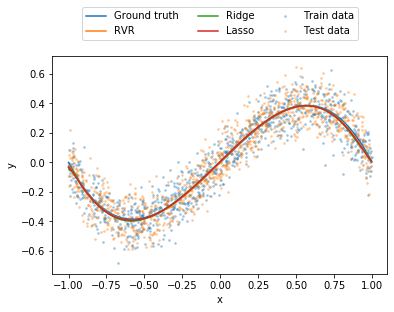

In [9]:
# Comparison
print('Relevance Vector Regression')
print('Features remaining:', np.sum(alpha_rvr < 1e8), '/', d)
print('Train error:', l2_error(X_train, t_train, w_rvr) / n)
print('Test error: ', l2_error(X_test, t_test, w_rvr) / n)
print('-'*50)
print('Ridge Regression')
print('Features remaining: NA (no sparsity)')
print('Train error:', l2_error(X_train, t_train, w_ridge) / n)
print('Test error: ', l2_error(X_test, t_test, w_ridge) / n)
print('-'*50)
print('Lasso Regression')
print('Features remaining:', np.sum(np.abs(w_lasso) > 1e-20), '/', d)
print('Train error:', l2_error(X_train, t_train, w_lasso) / n)
print('Test error: ', l2_error(X_test, t_test, w_lasso) / n)

fig, ax = plt.subplots()
ax.scatter(X_train[:, 1], t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(X_test[:, 1], t_test, s=3, label='Test data', alpha=0.3)
ax.plot(X_train[:, 1], X_train.dot(w_true), label='Ground truth')
ax.plot(X_train[:, 1], X_train.dot(w_rvr), label='RVR')
ax.plot(X_train[:, 1], X_train.dot(w_ridge), label='Ridge')
ax.plot(X_train[:, 1], X_train.dot(w_lasso), label='Lasso')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

## Регрессия с RBF-признаками

Здесь решается другая модельная задача: необходимо восстановить зашумленную функцию `sinc(x)`. Предлагается применить kernel trick с RBF-ядром (можно использовать функцию `sklearn.metrics.pairwise.rbf_kernel`), обучить три модели: SVM-регрессию (SVR), L1-регрессию (Lasso) и RVR, и сравнить ошибку на тестовой выборке и качество отобранных опорных / релевантных объектов.

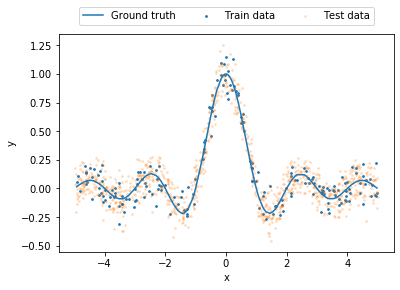

In [10]:
# Data generation
from sklearn.metrics.pairwise import rbf_kernel

def gen_batch(n, beta):
    points = np.random.uniform(-5, 5, n)
    points = np.sort(points)
    t = np.sinc(points) + np.random.normal(size=n) / beta ** 0.5
    return points, t

n = 200
n_test = 1000
d = n + 1
beta_true = 100

points_train, t_train = gen_batch(n, beta_true)
points_test, t_test = gen_batch(n_test, beta_true)

# RBF-transform
X_train = rbf_kernel(points_train.reshape(-1, 1), points_train.reshape(-1, 1)) # YOUR CODE GOES HERE
X_test = rbf_kernel(points_test.reshape(-1, 1), points_train.reshape(-1, 1)) # YOUR CODE GOES HERE

# Constant feature
X_train = np.hstack((np.ones((n, 1)), X_train))
X_test = np.hstack((np.ones((n_test, 1)), X_test))

# Visualization
fig, ax = plt.subplots()
ax.scatter(points_train, t_train, s=3, label='Train data', alpha=1)
ax.scatter(points_test, t_test, s=3, label='Test data', alpha=0.2)
ax.plot(points_train, np.sinc(points_train), label='Ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.15))
plt.show()

In [11]:
# Relevance Vector Regression
w_rvr, sigma_rvr, alpha_rvr, beta_rvr = fit_rvr(X_train, t_train, 20000)

100%|██████████| 20000/20000 [01:05<00:00, 306.20it/s]


In [12]:
# Lasso Regression with Cross-Validation
from sklearn.linear_model import LassoCV
lasso = LassoCV(cv=10, alphas=10.**np.linspace(-5, 1, 20),
                fit_intercept=False, max_iter=100000, tol=1e-2, n_jobs=10).fit(X_train, t_train)
w_lasso = lasso.coef_

In [13]:
# Support Vector Regression
from sklearn.svm import SVR
svr = SVR(gamma=1, tol=1e-6, C=1).fit(points_train.reshape(-1, 1), t_train)

Relevance Vector Regression
Objects remaining: 24 / 200
Train error: 0.008067403165581594
Test error:  0.053569623805971654
--------------------------------------------------
Lasso Regression
Objects remaining: 68 / 200
Train error: 0.007901461301410777
Test error:  0.05233162453458753
--------------------------------------------------
Support Vector Regression
Objects remaining: 65 / 200
Train error: 0.008155320995117501
Test error:  0.0535099857465692


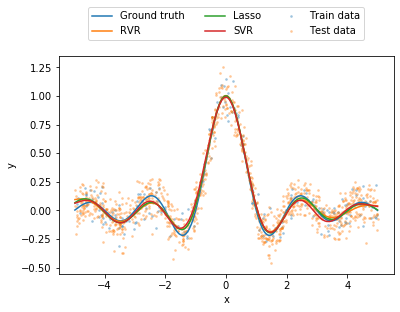

In [14]:
# Comparison
print('Relevance Vector Regression')
print('Objects remaining:', np.sum(alpha_rvr[1:] < 1e8), '/', n)
print('Train error:', l2_error(X_train, t_train, w_rvr) / n)
print('Test error: ', l2_error(X_test, t_test, w_rvr) / n)
print('-'*50)
print('Lasso Regression')
print('Objects remaining:', np.sum(np.abs(w_lasso[1:]) > 1e-20), '/', n)
print('Train error:', l2_error(X_train, t_train, w_lasso) / n)
print('Test error: ', l2_error(X_test, t_test, w_lasso) / n)
print('-'*50)
print('Support Vector Regression')
print('Objects remaining:', len(svr.support_), '/', n)
print('Train error:', np.sum((svr.predict(points_train.reshape(-1, 1)) - t_train) ** 2) / n)
print('Test error: ', np.sum((svr.predict(points_test.reshape(-1, 1)) - t_test) ** 2) / n)

fig, ax = plt.subplots()
ax.scatter(points_train, t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(points_test, t_test, s=3, label='Test data', alpha=0.3)
ax.plot(points_test, np.sinc(points_test), label='Ground truth')
ax.plot(points_test, X_test.dot(w_rvr), label='RVR')
ax.plot(points_test, X_test.dot(w_lasso), label='Lasso')
ax.plot(points_test, svr.predict(points_test.reshape(-1, 1)), label='SVR')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

### Визуализация релевантных объектов для RVR

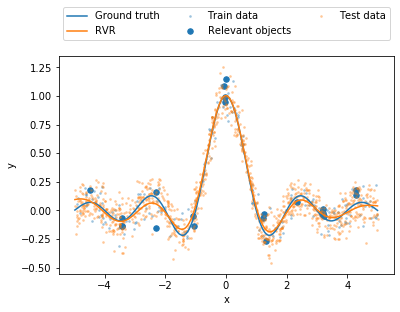

In [15]:
relevant = alpha_rvr[1:] < 1e8
fig, ax = plt.subplots()
ax.scatter(points_train, t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(points_train[relevant], t_train[relevant], c='tab:blue', s=30, label='Relevant objects')
ax.scatter(points_test, t_test, s=3, label='Test data', alpha=0.3)
ax.plot(points_test, np.sinc(points_test), label='Ground truth')
ax.plot(points_test, X_test.dot(w_rvr), label='RVR')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

## Выводы
1. Relevance Vector Machine оставляет меньше признаков, чем Lasso или SVM
2. Во многих случаях ошибка алгоритма на тренировочной выборке, больше по сравнению с другими алгоритмами. Однако, ошибка на отложенной выборке во многих случаях оказывается меньше чем у других алгоритмов
3. 